1. Id number: 1 to 214
2. RI: refractive index
3. Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
4. Mg: Magnesium
5. Al: Aluminum
6. Si: Silicon
7. K: Potassium
8. Ca: Calcium
9. Ba: Barium
10. Fe: Iron
11. Type of glass: (class attribute)
    - 1 building_windows_float_processed
    - 2 building_windows_non_float_processed
    - 3 vehicle_windows_float_processed
    - 4 vehicle_windows_non_float_processed (none in this database)
    - 5 containers
    - 6 tableware
    - 7 headlamps
    

Float Processed: silica sand (73%), calcium oxide (9%), soda (13%) and magnesium (4%)
Non_Float_Processed: 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv("https://query.data.world/s/s5esdu4atjb3mqxafc5rxqfdx36pax")
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
df.shape

(214, 10)

In [4]:
df.Type.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: Type, dtype: int64

**Since we are going to perfrom unsupervised clustering task, we will not be using "Type" variable and hence we are going to drop it.**

In [5]:
df1 =df.drop(columns = 'Type')

In [6]:
df1.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0


Since here we don't have any identity for each glass, we will be creating a new column where we will be having a unique number given to each glass and this will help us to find out which glass belong to which cluster during the cluster profiling stage.


The reason we can't use index of the dataframe as id variable because, it might get change as we make any manipulation to the data.

In [7]:
df1['ID'] = df1.index

In [8]:
df1.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,ID
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,2
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,3
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,4


**Steps For Clustering**

- Pre-process
    - Outlier Treatment
    - Scaling
- Cluster tendency
    - Hopkins stats
- Find the best value of k
    - Business understanding
    - silhouette
    - elbow
- Final k mean with the chosen value of k
- Cluster Profiling

### Pre-Processing

In [9]:
df1.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,ID
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,2
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,3
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,4


In [12]:
f = df1.columns[:-1]

In [17]:
f

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'], dtype='object')

In [16]:
list(enumerate(f))

[(0, 'RI'),
 (1, 'Na'),
 (2, 'Mg'),
 (3, 'Al'),
 (4, 'Si'),
 (5, 'K'),
 (6, 'Ca'),
 (7, 'Ba'),
 (8, 'Fe')]

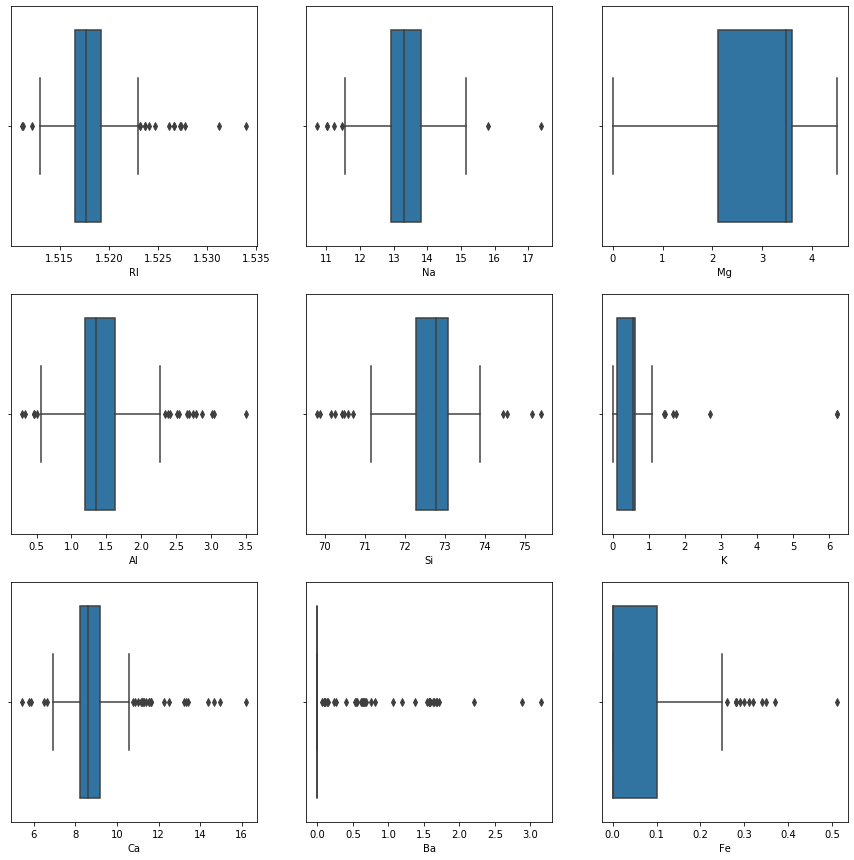

In [14]:
plt.figure(figsize = (15,15))
for i,j in enumerate(f):
    plt.subplot(3,3,i+1)
    sns.boxplot(x = j, data =df1)

**Various Ways To Dela With Outliers**

- If all the columns or most of the columns in your given data are having outliers in a certain range(upper or lower), ignore all the outliers. They might form a cluster of themselves.
- But we need to deal with the extreem outliers.
- Now, if we have good amount of data with us, we may drop them
- But if we have less data, we prefer to cap them using soft capping (1-99)

In [19]:
df1['RI'].quantile(0.99)

1.5277206

In [22]:
# df1[df1['RI']>1.5277206]['RI'] = 1.5277206

106    1.53125
107    1.53393
112    1.52777
Name: RI, dtype: float64

In [23]:
f

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'], dtype='object')

In [24]:
## Soft Capp

for i in f:
    v99 = df1[i].quantile(0.99)
    df1[df1[i]>=v99][i] = v99

C:\Users\SUMITH\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


**Scaling**

In [25]:
df1.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,ID
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,2
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,3
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,4


In [28]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
df2 = ss.fit_transform(df1.drop(columns = 'ID'))
df2

array([[ 0.87286765,  0.28495326,  1.25463857, ..., -0.14576634,
        -0.35287683, -0.5864509 ],
       [-0.24933347,  0.59181718,  0.63616803, ..., -0.79373376,
        -0.35287683, -0.5864509 ],
       [-0.72131806,  0.14993314,  0.60142249, ..., -0.82894938,
        -0.35287683, -0.5864509 ],
       ...,
       [ 0.75404635,  1.16872135, -1.86551055, ..., -0.36410319,
         2.95320036, -0.5864509 ],
       [-0.61239854,  1.19327046, -1.86551055, ..., -0.33593069,
         2.81208731, -0.5864509 ],
       [-0.41436305,  1.00915211, -1.86551055, ..., -0.23732695,
         3.01367739, -0.5864509 ]])

In [29]:
df2 = pd.DataFrame(df2)

In [30]:
df2

,0,1,2,3,4,5,6,7,8
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451
...,...,...,...,...,...,...,...,...,...
209,-0.704815,0.898681,-1.865511,2.881125,-0.052974,-0.640968,0.157088,1.783978,-0.586451
210,-0.500178,1.856097,-1.865511,1.094342,0.529374,-0.763919,-0.392276,2.852405,-0.586451
211,0.754046,1.168721,-1.865511,1.154570,0.995252,-0.763919,-0.364103,2.953200,-0.586451
212,-0.612399,1.193270,-1.865511,0.993960,1.241133,-0.763919,-0.335931,2.812087,-0.586451


In [31]:
df2.columns  = f

In [32]:
df2.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451


#### Hopkins

In [33]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [34]:
hopkins(df2)

0.9099205856239825

Here, we need to get a value of more than 0.8 for our data to have visible clusters.

### Find the best value of K

- Business Understanding: K = 3(Building, Vehicle, HomeWare)

**Silhouette Score**

In [35]:
from sklearn.metrics import silhouette_score

sil = []

for k in range(2,11):
    kmean = KMeans(n_clusters = k, random_state = 0).fit(df2)
    sil.append([k, silhouette_score(df2, kmean.labels_)])

In [37]:
sil = pd.DataFrame(sil)
sil

,0,1
0,2,0.419481
1,3,0.367194
2,4,0.390963
3,5,0.350182
4,6,0.323658
5,7,0.337085
6,8,0.355106
7,9,0.360750
8,10,0.244809


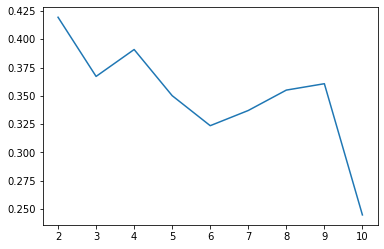

In [38]:
plt.plot(sil[0], sil[1])

**Elbow Curve**

In [39]:
ssd = []

for k in range(2,11):
    kmean = KMeans(n_clusters = k, random_state = 0).fit(df2)
    ssd.append([k, kmean.inertia_])

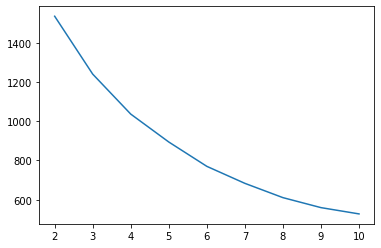

In [40]:
ssd = pd.DataFrame(ssd)
plt.plot(ssd[0], ssd[1])

k= 3

**Final K Mean**

In [42]:
kmeans = KMeans(n_clusters = 3, random_state = 0)
kmeans.fit(df2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [43]:
kmeans.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 0,
       2, 2, 2, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 0, 1, 2, 0, 0, 0, 2, 0, 0, 2, 2, 0, 0, 0,
       2, 0, 2, 2, 2, 1, 1, 0, 1, 2, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [44]:
df2.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451


In [45]:
df1.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,ID
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,2
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,3
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,4


In [46]:
df1['label'] = kmeans.labels_

In [47]:
df1.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,ID,label
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,0,2
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1,2
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,2,2
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,3,2
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,4,2


In [48]:
df1['label'].value_counts()

2    139
0     46
1     29
Name: label, dtype: int64

### Cluster Profiling

In [49]:
f

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe'], dtype='object')

In [50]:
ff = ['K', 'Ca', 'Ba', 'Fe']

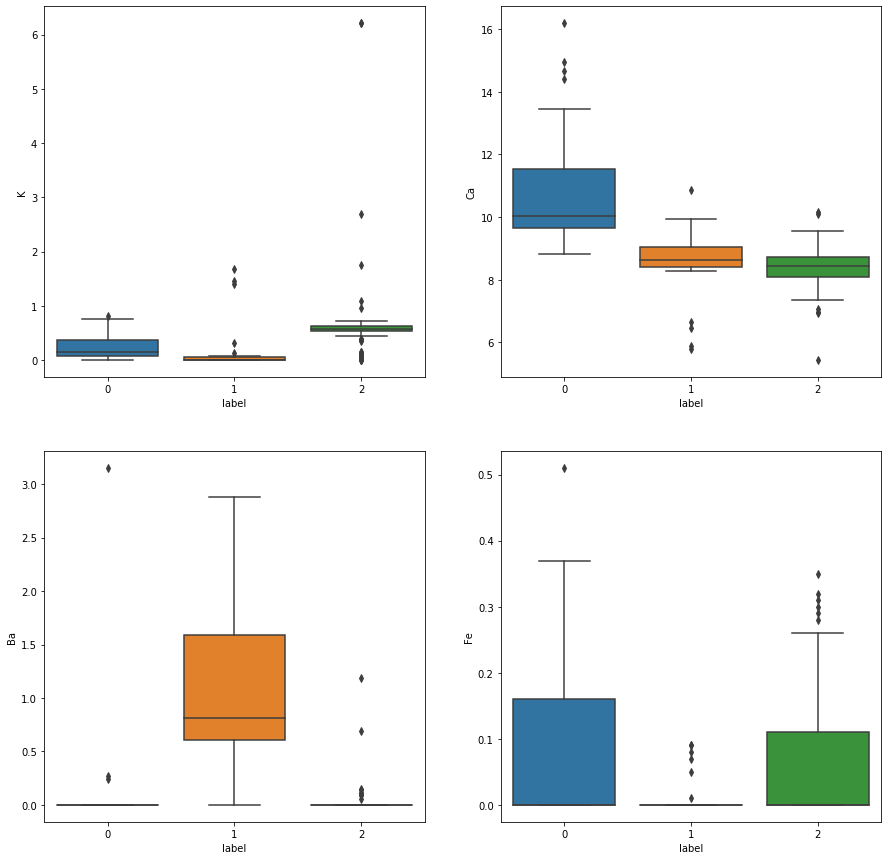

In [51]:
plt.figure(figsize = (15,15))
for i,j in enumerate(ff):
    plt.subplot(2,2,i+1)
    sns.boxplot(x = 'label', y = j, data =df1)

- Homeware glasses: Ca+Fe
- Vechile: Ba Rich
- Building: Fe+Ca